In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize, blankline_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string  # Add this import for handling punctuation
from transformers import GPT2LMHeadModel, GPT2Tokenizer # for perplexity
import torch # for perplexity calculation
import re # for n gram calculation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC # support vector machine
from sklearn.metrics import accuracy_score
from scipy.sparse import hstack
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from datetime import datetime
from sklearn.feature_selection import SelectKBest, chi2
import joblib
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Load the dataset
data = pd.read_csv('/content/drive/My Drive/ResearchProject/Dataset/final_dataset.csv')
#print(data.head())


Mounted at /content/drive


In [5]:
def preprocess_text(cleaned_data):
    cleaned_data.fillna('NULL', inplace=True)

    # Data conversion
    cleaned_data['text'] = cleaned_data['text'].astype('str').apply(lambda x: x.lower())
    # Remove duplicate rows
    cleaned_data = cleaned_data.drop_duplicates()

    #cleaned_data['text'] = cleaned_data['text'].str.lower()

    def count_lengths(text):
        # Tokenize into sentences and paragraphs
        sentences = sent_tokenize(text)
        # Count lengths
        num_sentences = len(sentences)
        sentence_lengths = [len(sent.split()) for sent in sentences]
        average_sentence_length = sum(sentence_lengths)/len(sentence_lengths)

        return num_sentences, average_sentence_length

    # Apply the function and assign to temporary variable
    cleaned_data[['num_sentences', 'average_sentence_length']] = cleaned_data['text'].apply(count_lengths).apply(pd.Series)

    # Remove punctuation
    cleaned_data['text'] = cleaned_data['text'].apply(lambda x: ''.join([word for word in x if word not in string.punctuation]))

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    cleaned_data['text'] = cleaned_data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

    # Stemming
    porter = PorterStemmer()
    cleaned_data['text'] = cleaned_data['text'].apply(lambda x: ' '.join([porter.stem(word) for word in x.split()]))

    # Function to calculate paragraph length
    def calculate_paragraph_length(text):
        # Split text into paragraphs based on newline character
        paragraphs = text.split("\n")
        # Count number of words in each paragraph
        paragraph_lengths = [len(paragraph.split()) for paragraph in paragraphs]

        return paragraph_lengths

    #Apply function for paragraph length
    cleaned_data['paragraph_length'] = cleaned_data['text'].apply(calculate_paragraph_length)

    # Tokenization
    nltk.download('punkt')
    cleaned_data['tokenized_text'] = cleaned_data['text'].apply(lambda x: word_tokenize(x))

    return cleaned_data

In [4]:

def feature_extract(filepath):
  cleaned_data = pd.read_csv(filepath)

  # Perplexity calculation
  # Load pre-trained GPT-2 model and tokenizer
  model = GPT2LMHeadModel.from_pretrained("gpt2")
  tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

  # Function to calculate perplexity of a text
  def calculate_perplexity(text):
      # Tokenize the text
      input_ids = tokenizer.encode(text, return_tensors="pt", max_length=512, truncation=True)
      # Calculate perplexity
      with torch.no_grad():
          loss = model(input_ids, labels=input_ids)[0]
          perplexity = torch.exp(loss)
      return perplexity.item()

  def extract_ngrams(text, n):
      # Define the regular expression pattern to match n-grams
      pattern = r'\b\w+\b'  # Matches individual words (word boundaries included)
      ngram_pattern = r'\b(?:\w+\s+){' + str(n-1) + r'}\w+\b'  # Matches n-grams of size n

      # Find all matches of the n-gram pattern in the text
      ngrams = re.findall(ngram_pattern, text)

      return ngrams

  # Add a new column for perplexity
  cleaned_data["perplexity"] = cleaned_data["tokenized_text"].apply(calculate_perplexity)

  #n-gram calculation
  n = 1  # Specify the desired n-gram size

  for n in range(1, 4):
    cleaned_data[f'{n}-grams'] = cleaned_data['text'].apply(lambda x: extract_ngrams(x, n))

  return cleaned_data


In [6]:
#Train the SVM model

# Split the dataset into training, validation, and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)

# Define features and labels
X_train_text = train_data['text']
X_val_text = val_data['text']
X_test_text = test_data['text']

y_train = train_data['generated']
y_val = val_data['generated']
y_test = test_data['generated']

X_train_other = train_data.drop(columns=['Unnamed: 0', 'text', 'generated'])  # Exclude 'Unnamed: 0', 'text', 'generated'
X_val_other = val_data.drop(columns=['Unnamed: 0', 'text', 'generated'])
X_test_other = test_data.drop(columns=['Unnamed: 0', 'text', 'generated'])

#Converting non-numerical features to numerical features
encoder = OneHotEncoder(handle_unknown='ignore')
X_train_other_encoded = encoder.fit_transform(X_train_other[['tokenized_text', 'bigrams', 'trigrams', 'unigram', 'paragraph_length']])
X_val_other_encoded = encoder.transform(X_val_other[['tokenized_text', 'bigrams', 'trigrams', 'unigram', 'paragraph_length']])
X_test_other_encoded = encoder.transform(X_test_other[['tokenized_text', 'bigrams', 'trigrams', 'unigram', 'paragraph_length']])

# Select the top 5 most important categorical features
selector = SelectKBest(chi2, k=5)
X_train_other_encoded = selector.fit_transform(X_train_other_encoded, y_train)
X_val_other_encoded = selector.fit_transform(X_val_other_encoded, y_val)
X_test_other_encoded = selector.fit_transform(X_test_other_encoded, y_test)

#Converting numerical features to float type
selected_features = ['num_sentences','average_sentence_length', 'perplexity']
X_train_other_selected = X_train_other[selected_features].astype(float).values
X_val_other_selected = X_val_other[selected_features].astype(float).values
X_test_other_selected = X_test_other[selected_features].astype(float).values

# TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
X_val_tfidf = tfidf_vectorizer.transform(X_val_text)
X_test_tfidf = tfidf_vectorizer.transform(X_test_text)

# Combine TF-IDF vectors with other features
X_train = hstack((X_train_tfidf, X_train_other_selected, X_train_other_encoded))
X_val = hstack((X_val_tfidf, X_val_other_selected, X_val_other_encoded))
X_test = hstack((X_test_tfidf, X_test_other_selected, X_test_other_encoded))

start_timestamp = datetime.now()
start_timestamp = start_timestamp.strftime("%Y-%m-%d %H:%M:%S")
print("Start timestamp: ", start_timestamp)

# Train SVM model
svm_model = LinearSVC(dual=False)
svm_model.fit(X_train, y_train)

end_timestamp = datetime.now()
end_timestamp = end_timestamp.strftime("%Y-%m-%d %H:%M:%S")
print("End timestamp: ", end_timestamp)

# Predictions on validation set
val_predictions = svm_model.predict(X_val)
val_report = classification_report(y_val, val_predictions)
print("Evaluation Metrics for SVM Model")
print("Validation Set Metrics:\n", val_report)

# Predictions on test set
test_predictions = svm_model.predict(X_test)
test_report = classification_report(y_test, test_predictions)
print("Test Set Metrics:\n", test_report)

total_features = X_train_tfidf.shape[1] + X_train_other_selected.shape[1] + X_train_other_encoded.shape[1]
print("Total number of features:", total_features)
print("tfidf:", X_train_tfidf.shape)
print("selected:", X_train_other_selected.shape)
print("encoded:", X_train_other_encoded.shape)


Start timestamp:  2024-05-12 16:02:52
End timestamp:  2024-05-12 16:03:01
Evaluation Metrics for SVM Model
Validation Set Metrics:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      2335
           1       0.99      0.99      0.99      2907

    accuracy                           0.99      5242
   macro avg       0.99      0.99      0.99      5242
weighted avg       0.99      0.99      0.99      5242

Test Set Metrics:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      2351
           1       0.99      0.99      0.99      2891

    accuracy                           0.99      5242
   macro avg       0.99      0.99      0.99      5242
weighted avg       0.99      0.99      0.99      5242

Total number of features: 131343
tfidf: (41933, 131335)
selected: (41933, 3)
encoded: (41933, 5)


In [8]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation with 5 folds
cv_scores = cross_val_score(svm_model, X_train, y_train, cv=5)

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())
print("Standard Deviation of CV Accuracy:", cv_scores.std())


Cross-Validation Scores: [0.98604984 0.98545368 0.98616907 0.98652516 0.98592893]
Mean CV Accuracy: 0.9860253357360236
Standard Deviation of CV Accuracy: 0.00034847439056429037


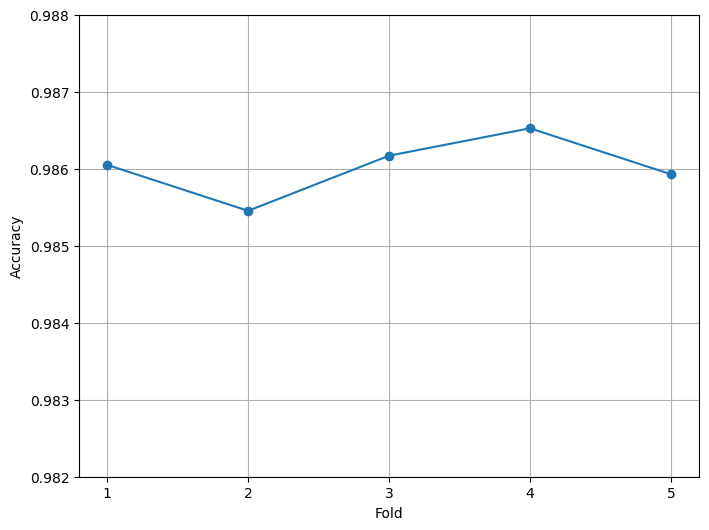

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Generate fold indices for plotting
fold_indices = np.arange(1, len(cv_scores) + 1)

# Plot a line plot of the cross-validation scores
plt.figure(figsize=(8, 6))
plt.plot(fold_indices, cv_scores, marker='o', linestyle='-')
# plt.title('Cross-Validation Scores')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.xticks(fold_indices)
plt.grid(True)
plt.ylim(0.982, 0.988)

plt.show()


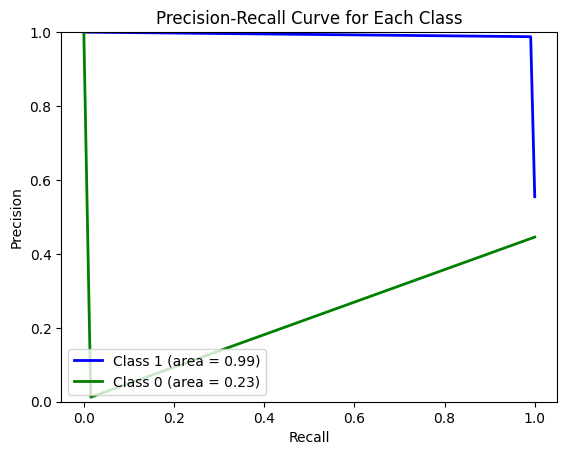

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

# Calculate precision and recall for class 1
precision_class1, recall_class1, _ = precision_recall_curve(y_val, val_predictions, pos_label=1)
# Calculate area under curve (AUC) for Precision-Recall curve for class 1
pr_auc_class1 = auc(recall_class1, precision_class1)

# Calculate precision and recall for class 0
precision_class0, recall_class0, _ = precision_recall_curve(y_val, val_predictions, pos_label=0)
# Calculate area under curve (AUC) for Precision-Recall curve for class 0
pr_auc_class0 = auc(recall_class0, precision_class0)

# Plot Precision-Recall curves for both classes
plt.figure()
plt.plot(recall_class1, precision_class1, color='blue', lw=2, label='Class 1 (area = %0.2f)' % pr_auc_class1)
plt.plot(recall_class0, precision_class0, color='green', lw=2, label='Class 0 (area = %0.2f)' % pr_auc_class0)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Class')
plt.legend(loc="lower left")
plt.ylim(0, 1)
plt.show()


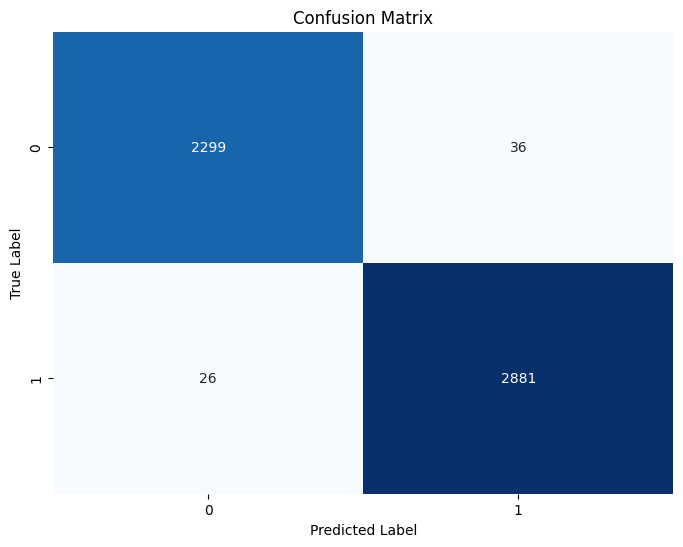

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_val, val_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
# # Saving model and tfidf files
# import joblib

# joblib.dump(svm_model, '/content/drive/My Drive/ResearchProject/svm_model.pkl')
# joblib.dump(tfidf_vectorizer,'/content/drive/My Drive/ResearchProject/tfidf_vectorizer.pkl')

In [13]:
# Load pre-trained SVM model
model = joblib.load('/content/drive/My Drive/ResearchProject/svm_model.pkl')

# Load TF-IDF vectorizer (if used during training)
tfidf_vectorizer = joblib.load('/content/drive/My Drive/ResearchProject/tfidf_vectorizer.pkl')

In [14]:
#Deployement of model

def take_text_prompt():
    print("Please enter your text below:")

    user_text = input("> ")
    return user_text

# Prediction function
def predict(filepath):
    dataframe = pd.read_csv(filepath)
    df_text = dataframe['text']
    df_num_sentences = dataframe['num_sentences']
    df_avg_sentence_length = dataframe['average_sentence_length']
    df_paragraph_length = dataframe['paragraph_length'] #converting to average paragraph length
    df_tokenized_text = dataframe['tokenized_text']
    df_perplexity = dataframe['perplexity']
    df_1grams = dataframe['1-grams']
    df_2grams = dataframe['2-grams']
    df_3grams = dataframe['3-grams']

    #Converting non-numerical features to numerical features
    encoder = OneHotEncoder(handle_unknown='ignore')
    df_other_encoded = encoder.fit_transform(dataframe[['tokenized_text', '2-grams', '3-grams', '1-grams', 'paragraph_length']])

    #Converting numerical features to float type
    selected_features = ['num_sentences','average_sentence_length', 'perplexity']
    df_other_selected = dataframe[selected_features].astype(float).values

    # Vectorize text data using TF-IDF vectorizer
    if tfidf_vectorizer:
        vectorized_text = tfidf_vectorizer.transform(df_text.values)
    else:
        # Apply any other necessary encoding
        pass

    print("Shape of TF-IDF vectorized text data:", vectorized_text.shape)
    print('selected:', df_other_selected.shape)
    print('encoded:', df_other_encoded.shape)


    # Combine all features
    df_combined = hstack((vectorized_text, df_other_selected, df_other_encoded))

    # Make prediction using the trained SVM model
    prediction = model.predict(df_combined)
    return prediction


if __name__ == "__main__":
    text = take_text_prompt()
    # Create a DataFrame with one column 'text'
    cleaned_data = pd.DataFrame({'text': [text]})

    cleaned_data = preprocess_text(cleaned_data)

    cleaned_data.to_csv('/content/drive/My Drive/ResearchProject/cleaned.csv')

    final_df = feature_extract('/content/drive/My Drive/ResearchProject/cleaned.csv')

    print("\nPre-processed Sample:")
    print(final_df)

    final_df.to_csv('/content/drive/My Drive/ResearchProject/test.csv')

    start_timestamp = datetime.now()
    start_timestamp = start_timestamp.strftime("%Y-%m-%d %H:%M:%S.%f")
    print("Start timestamp: ", start_timestamp)


    result = predict('/content/drive/My Drive/ResearchProject/test.csv')
    print("Predicted class:", result)
    # Train SVM model

    end_timestamp = datetime.now()
    end_timestamp = end_timestamp.strftime("%Y-%m-%d %H:%M:%S.%f")
    print("End timestamp: ", end_timestamp)


    if result == 1:
      print("This is written by AI")
    elif result == 0:
      print("This is written by Human")
    else:
      print("Please try again")

Please enter your text below:
> The chemical compound, ethanol, has risen in recent years as the most viable alternative to fossil fuels. Ethanol is a renewable fuel made from crops, mainly from corn in the United States, which can power engines. There are many who argue that corn ethanol should replace fossil fuel gas as the primary source for running cars.  One major benefit of using corn ethanol is that it uses less energy than gasoline. Using less energy means that people can get better gas mileage while driving these more fuel-efficient cars. In the long-run, this will be cheaper for consumers because they can drive further than they do now with fossil-fueled cars. People will spend less money on gas because they won’t have to stop to fill up as frequently.  Another advantage of switching to corn ethanol is that it helps the American economy become less reliant on energy sources from other countries. Petroleum is not readily available in the U.S., so it must be imported from other

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]


Pre-processed Sample:
   Unnamed: 0                                               text  \
0           0  chemic compound ethanol risen recent year viab...   

   num_sentences  average_sentence_length paragraph_length  \
0           17.0                17.705882            [168]   

                                      tokenized_text  perplexity  \
0  ['chemic', 'compound', 'ethanol', 'risen', 're...   15.185644   

                                             1-grams  \
0  [chemic, compound, ethanol, risen, recent, yea...   

                                             2-grams  \
0  [chemic compound, ethanol risen, recent year, ...   

                                             3-grams  
0  [chemic compound ethanol, risen recent year, v...  
Start timestamp:  2024-05-12 16:55:57.865376
Shape of TF-IDF vectorized text data: (1, 131335)
selected: (1, 3)
encoded: (1, 5)
Predicted class: [0]
End timestamp:  2024-05-12 16:55:57.938412
This is written by Human
